In [ ]:
### First we have downloaded a net CDF from the Copernicus Data Store: https://cds.climate.copernicus.eu

### Required Changes:

- The complete table should be saved in the directory: `data/generated/index_table_output`
    - The file name must include the start and end dates for easier identification.

- For the functions `generate_etccdi_temporal_tables` and `generate_etccdi_temporal_tables__centroid`:
    - Suppress the printing of each graphic iteration during execution to reduce unnecessary output.

- Ensure that all generated graphics reference a single, consistent scale (legend).

- Issue with validation if:
    - partial years are set in the parameters option 
    - ex. monthly data is allowed but parameters request only part of given year.


# To-Do List

## dependencies file
- This is started as requirements.tx
    - Go through each function (.py) and pull out all dependencies 
    - compile into one simplified list
    - consult viewser and check which are absent
    - make list of just the absent to install before running

## Decision Tree Development
- Create a **decision tree for defensible methods** based on different applications:
    - If performing at an admin or country scale, use method X.
    - Address the question: "At what scale does the utility of finer-grained PRIOgrid data diminish?" 
    - Incorporate considerations of 'other' shapefile extents.

## API Considerations
- Investigate potential **API changes**:
    1. Ensure the `define_request.py` script is correctly referenced.
    2. Contact CDS to determine their API update schedule (e.g., every 6 months or yearly).
    3. Check the **CDS API forum** for transparency on updates.

## Feature Enhancements
- Add **descriptive statistics**:
    - Include basic summary stats for the requested indices.
- Allow users to view country-specific data:
    - Avoid packaging into larger datasets.
  
## Additional Notes
- Add a **section in the documentation** clarifying how to migrate workflows smoothly.


In [14]:
import pandas as pd
import xarray as xr
import numpy as np

In [15]:
from setup_environment import setup_utils_path
setup_utils_path()

Utils path already in Python Path.


In [16]:

# Format API Request ----------------------------------------------------------------
from unzip import unzip_etccdi_package
from correct_longitude import transform_longitudinal_values
from temporal_index import find_etccdi_timeindex, translate_index_to_daterange
from define_request import generate_and_validate_request

# Provide Metadata ------------------------------------------------------------------
from give_metadata import give_metadata

# Build API Request -----------------------------------------------------------------
from cds_api_pull import pull_from_cds_api

# Methods ---------------------------------------------------------------------------
from etccdi_to_pg__pointquery import generate_etccdi_temporal_tables__centroid
from etccdi_to_pg import generate_etccdi_temporal_tables

# Validation ------------------------------------------------------------------------
from give_reference_frame import provide_reference_frame
from id_null_values import report_null_etccdi_values

## Access with Copernicus Data Store API:

### You must have both a Copernicus Data Store account and have followed the proceeding instructions on setting up the CDSAPI before you can retrieve and process data from this toolbox. 

#### The following instructions reference the CDSAPI set up guide: https://cds.climate.copernicus.eu/how-to-api


The final objective is to construct a main.py function that accepts the parameters below and automatically computes the process!

## API Request and Processing Parameters

### API Request Parameters
These parameters define the data retrieved via the API request:
- **`variable`**: Specifies the data variable of interest.
- **`product_type`**: Indicates the base product type.
- **`experiment`**: Defines the experimental setup or scenario.
- **`temporal_aggregation`**: Determines the temporal resolution of the data.

### Processing Parameters
These parameters guide the processing workflow:
- **`start_year`**: `'1995'`
- **`start_month`**: `'01'`
- **`end_year`**: `'2000'`
- **`end_month`**: `'12'`

### Method Selection
Choose a resampling or data alignment method:
- **Bilinear sampling**: Applies weighted interpolation for smoother results.
- **Point neighbor**: Maps the closest neighboring value preserving the original coarse resolution.

### (In Development) Extent Selection
Additional options for spatial analysis:
- Empirical distributions based on basin-specific extents.
- Future iterations will enable a 'hotspot' methodology for comparison with global metrics.


## Example of CDS Request

```
import cdsapi

dataset = "sis-extreme-indices-cmip6"
request = {
    "variable": ["cold_days"], 
    "product_type": ["base_period_1961_1990"],
    "model": ["hadgem3_gc31_ll"],
    "ensemble_member": ["r1i1p1f3"],
    "experiment": ["ssp1_2_6"],
    "temporal_aggregation": ["monthly"],
    "period": ["201501_210012"],
    "version": ["2_0"]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()
```   
``` 
dataset = "sis-extreme-indices-cmip6"
request = {
    "variable": ["consecutive_dry_days"],
    "product_type": ["base_independent"],
    "model": ["hadgem3_gc31_ll"],
    "ensemble_member": ["r1i1p1f3"],
    "experiment": ["ssp1_2_6"],
    "temporal_aggregation": ["yearly"],
    "period": ["2015_2100"],
    "version": ["2_0"]
}
```


### Product Type and Variable Temporal Aggregation

| product_type            | variable                           | temporal_aggregation |
|-------------------------|------------------------------------|----------------------|
| base_independent         | consecutive_dry_days               | annual               |
| base_independent         | consecutive_wet_days               | annual               |
| base_independent         | diurnal_temperature_range          | monthly or annual    |
| base_independent         | frost_days                         | annual               |
| base_independent         | growing_season_length              | annual               |
| base_independent         | heavy_precipitation_days           | annual               |
| base_independent         | ice_days                           | annual               |
| base_independent         | maximum_1_day_precipitation        | monthly or annual    |
| base_independent         | maximum_5_day_precipitation        | monthly or annual    |
| base_independent         | maximum_value_of_daily_maximum_temperature | monthly or annual    |
| base_independent         | minimum_value_of_daily_maximum_temperature | monthly or annual    |
| base_independent         | maximum_value_of_daily_minimum_temperature | monthly or annual    |
| base_independent         | minimum_value_of_daily_minimum_temperature | monthly or annual    |
| base_independent         | number_of_wet_days                 | annual               |
| base_independent         | simple_daily_intensity_index       | annual               |
| base_independent         | summer_days                        | annual               |
| base_independent         | total_wet_day_precipitation        | annual               |
| base_independent         | tropical_nights                    | annual               |
| base_independent         | very_heavy_precipitation_days      | annual               |
| base_period_1961_1990    | cold_days                          | monthly or annual    |
| base_period_1961_1990    | cold_nights                        | monthly or annual    |
| base_period_1961_1990    | warm_days                          | monthly or annual    |
| base_period_1961_1990    | warm_nights                        | monthly or annual    |

The table above defines the `product_type`, `variable`, and the corresponding `temporal_aggregation` classification options for required parameters. Variables that are only available on a yearly basis are labeled as "annual," while others that can be reported on both monthly and annual bases are labeled as "monthly or annual."

### Experiment Period Mapping

| experiment  | period        |
|-------------|---------------|
| historical | 185001_201412 |
| ssp1_2_6   | 201501_210012 |
| SSP2_4_5   | 201501_210012 |
| SSP5_8_5   | 201501_210012 |


In [36]:
p_variable = "summer_days"
p_product_type="base_independent"
p_experiment="ssp1_2_6"
p_temporal_aggregation="yearly"

#-----------------------------------------------------------
# Define Start Year & Month
#-----------------------------------------------------------
start_year = '2015'
start_month = '01'
#-----------------------------------------------------------
# Define End Year & Month
end_year = '2016'
end_month = '04'
#-----------------------------------------------------------
method = 'resample' # or raster_query
#-----------------------------------------------------------
save_tif = 'no' # or no
#-----------------------------------------------------------

#country_selection = None

In [18]:
# Now, calling the function will generate and validate the request

request = generate_and_validate_request(
    variable=p_variable,
    product_type=p_product_type,
    experiment=p_experiment,
    temporal_aggregation=p_temporal_aggregation
)
temporal_aggregation_value = request['temporal_aggregation'][0]
print(temporal_aggregation_value)
display(request)

#-------------------------------------------------------------------
# Load a clean PG dataframe at a consistent temporal resolution
# to the request built
#-------------------------------------------------------------------

reference_df = provide_reference_frame(request)

Request is valid.
yearly


{'variable': ['summer_days'],
 'product_type': ['base_independent'],
 'model': ['hadgem3_gc31_ll'],
 'ensemble_member': ['r1i1p1f3'],
 'experiment': ['ssp1_2_6'],
 'temporal_aggregation': ['yearly'],
 'period': ['2015_2100'],
 'version': ['2_0'],
 'data_format': 'netcdf'}

priogrid_gid    int64
year            int64
dtype: object


The zip_file_name will appear in folder:

```
CLIMATE_EXTREMES/
├── data/
│   ├── raw_external/
│   │   └── cds_zip/
```

In [19]:
zip_file_name = pull_from_cds_api(request)

2024-11-21 11:45:50,418 WARNING [2024-11-19T00:00:00] Issue with underlaying infrastructure is now solved. System should gradually recover. Please check updated status [here](https://status.ecmwf.int/)
2024-11-21 11:45:50,418 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-21 11:45:50,419 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-21 11:45:50,420 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-21 11:45:50,420 WARNING [2024-06-16T00:00:00] CDS 

27c8625612bdcd7461123cf706b10d59.zip:   0%|          | 0.00/9.14M [00:00<?, ?B/s]

The netcdf file will appear in folder: 

```
CLIMATE_EXTREMES/
├── data/
│   ├── generated/
│   │   └── netcd/

```

In [20]:
netcdf_file, etccdi_index = unzip_etccdi_package(zip_file_name)

suETCCDI
Extracted file names: suETCCDI_yr_HadGEM3-GC31-LL_ssp126_r1i1p1f3_no-base_v20200114_2015-2100_v2-0.nc


The adjusted netcdf file replaced the original file in location:

```
CLIMATE_EXTREMES/
├── data/
│   ├── generated/
│   │   └── netcd/
```

In [21]:
etccdi = transform_longitudinal_values(etccdi_index, netcdf_file)

The variable 'suETCCDI' was found in the file path and the world continues to spin.
Original Latitude range: -89.375 to 89.375
Original Longitude range: 0.9375 to 359.0625
Adjusted Longitude range: -179.0625 to 179.0625
Adjusted dataset saved to: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/netcdf/adjusted_suETCCDI_yr_HadGEM3-GC31-LL_ssp126_r1i1p1f3_no-base_v20200114_2015-2100_v2-0.nc.nc


In [22]:
give_metadata(etccdi)

Latitude range: -89.375 to 89.375
Longitude range: -179.0625 to 179.0625
Latitude resolution: 1.25
Longitude resolution: 1.875
Global Metadata:
CDI: Climate Data Interface version 1.8.0 (http://mpimet.mpg.de/cdi)
history: Tue Nov 24 09:31:53 2020: cdo mergetime tasmax_day_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_20150101-20491230.nc tasmax_day_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_20500101-21001230.nc ./merged/tasmax_day_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_20150101-21001230.nc
2020-01-13T09:55:40Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.;
2020-01-13T09:53:59Z MIP Convert v1.2.3, Python v2.7.12, Iris v1.13.0, Numpy v1.13.3, netcdftime v1.4.1.
source: HadGEM3-GC31-LL (2016): 
aerosol: UKCA-GLOMAP-mode
atmos: MetUM-HadGEM3-GA7.1 (N96; 192 x 144 longitude/latitude; 85 levels; top level 85 km)
atmosChem: none
land: JULES-HadGEM3-GL7.1
landIce: none
ocean: NEMO-HadGEM3-GO6.0 (eORCA1 tripolar primarily 1 deg with meridional refinement down to 1/3 degree in the 

In [23]:
index_list, reference_filtered_time, report_temporal_dimensions = translate_index_to_daterange(etccdi, reference_df, temporal_aggregation_value, start_year, start_month, end_year, end_month)

No data found for 01 of the year 2015 but located data for the first available month.
Validation: Found data for Year: 2015, Month: 06 at index 0.

No data found for 04 of the year 2016 but located data for the first available month.
Validation: Found data for Year: 2016, Month: 06 at index 1.

The start index is: 0, and references 06 (month) of 2015 (year)

The end index is: 1, and references 06 (month) of 2016 (year)



### Params:

- time_index_list,
- netcdf, climate_index, 
- shapefile_path



Raster files:
```
CLIMATE_EXTREMES/
├── data/
│   ├── generated/
│   │   └── index_raster_output/
```

Final output table:
```
CLIMATE_EXTREMES/
├── data/
│   ├── generated/
│   │   └── index_table_output/
```


### Changes:

#### Do not print each iteration of the graphics!
- Complete for raster_query
- Finish for resample!

In [40]:
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
import xarray as xr
import geopandas as gpd
from rasterstats import zonal_stats
import pandas as pd
import os

import math  # Add this import at the top of your file
import geopandas as gpd


from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages  # Import PdfPages for saving PDF layouts
import tempfile

from rasterio.io import MemoryFile

def generate_layout_and_save(param_time_index_list, plot_figures, output_folder, param_climate_index):
    columns = 4
    rows = 3
    plots_per_page = columns * rows
    total_plots = len(plot_figures)
    total_pages = math.ceil(total_plots / plots_per_page)

    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)
    output_file = output_folder / f'{param_climate_index}_layout__resample.pdf'

    with PdfPages(output_file) as pdf:
        for page in range(total_pages):
            fig, axes = plt.subplots(rows, columns, figsize=(11.69, 8.27))  # A4 size in landscape
            axes = axes.flatten()

            for i in range(plots_per_page):
                plot_index = page * plots_per_page + i
                if plot_index < total_plots:
                    fig_plot = plot_figures[plot_index]
                    
                    # Remove x and y labels, but keep the axes and legend
                    for ax in fig_plot.get_axes():
                        ax.set_xlabel('')  # Remove x-axis label
                        ax.set_ylabel('')  # Remove y-axis label

                    # Save each figure to a temporary file, then load it
                    with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmpfile:
                        fig_plot.savefig(tmpfile.name, bbox_inches='tight')  # Save plot with legend
                        img = plt.imread(tmpfile.name)
                        axes[i].imshow(img)  # Place the image into the subplot axis
                        axes[i].axis('off')  # Turn off axis for a cleaner layout
                else:
                    axes[i].axis('off')  # Hide unused subplots

            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)

    print(f"All graphics saved to {output_file}")
    return output_file

def generate_etccdi_temporal_tables(param_time_index_list, param_netcdf, param_climate_index, temporal_params, save_raster, param_shapefile_name='pgm_viewser_extent.shp'):
    project_root = Path.cwd()  # Set this to your project root manually if needed

    map_folder = project_root / 'docs' / 'Graphics' / 'Standard_review'

    extent_path = project_root / 'data' / 'processed' / 'extent_shapefile'
    extent_filename = extent_path / param_shapefile_name


    out_originalraster_folder = project_root / 'data' / 'generated' / 'index_raster_output' /'native' 
    out_upsampleraster_folder = project_root / 'data' / 'generated' / 'index_raster_output' / 'method' / 'upsampled'

    generated_index_table_folder = project_root / 'data' / 'generated' / 'index_table_output'

    temporal_attribution = '_'.join(temporal_params)

    all_stats = []
    plot_figures = []  # Initialize list to store figures

    # Ensure the output folder exists
    #os.makedirs(output_folder, exist_ok=True)

    # Retrieve the first and last time indices for file naming
    first_time_index = param_time_index_list[0]
    last_time_index = param_time_index_list[-1]

    for i in param_time_index_list:
        print(f"Processing time index: {i}")
        
        # Select the data for the specified climate index
        data = param_netcdf[param_climate_index]
        
        # Check the data type and process accordingly
        data_type = data.dtype
        if data_type == 'timedelta64[ns]':
            data_days = data / np.timedelta64(1, 'D')  # Convert to days if it's timedelta
            raster_data = data_days.isel(time=i)
        elif data_type == 'float32':
            raster_data = data.isel(time=i)  # Use as-is if it's already float32
        else:
            raise TypeError(f"Unsupported data type '{data_type}' for variable '{param_climate_index}'. Expected 'timedelta64[ns]' or 'float32'.")
        
        # Convert spatial dimensions
        raster_data = raster_data.rename({'lon': 'x', 'lat': 'y'})
        raster_data = raster_data.rio.set_spatial_dims(x_dim='x', y_dim='y')

        # Get the date and time information
        date_time = str(param_netcdf['time'].isel(time=i).values.item())
        year, month = date_time.split('-')[:2]
        print("Year:", year, "Month:", month)

        # Set CRS if not already defined
        if not raster_data.rio.crs:
            print("CRS is not set. Setting CRS to EPSG:4326")
            raster_data = raster_data.rio.write_crs("EPSG:4326")

        # Save the original raster to the designated folder
        # --- original_raster_path = os.path.join(out_originalraster_folder, f"original_{param_climate_index}_{year}_{month}.tif")
        # ---- raster_data.rio.to_raster(original_raster_path)
        # ---- print(f"Original raster saved at: {original_raster_path}")

        # Create a separate raster with null values set to -9999
        # --- raster_with_nulls_set = raster_data.fillna(-9999)

        # Save the modified raster (with nulls as -9999) to the designated folder
        # --- null_set_raster_path = os.path.join(out_originalraster_folder, f"null_set_{param_climate_index}_{year}_{month}.tif")
        # --- raster_with_nulls_set.rio.to_raster(null_set_raster_path)
        # --- print(f"Raster with nulls set to -9999 saved at: {null_set_raster_path}")

        # Resample directly with bilinear interpolation
        def resample_with_bilinear(raster_data, factor=3):
            # Resample with the target shape
            upsampled_raster = raster_data.rio.reproject(
                raster_data.rio.crs,
                shape=(
                    int(raster_data.sizes['y'] * factor),
                    int(raster_data.sizes['x'] * factor)
                ),
                resampling=Resampling.bilinear
            )
            return upsampled_raster

        # Apply the resampling method
        upsampled_raster = resample_with_bilinear(raster_data, factor=20)

        # Plot the resampled raster
        plt.figure(figsize=(10, 6))
        upsampled_raster.plot(cmap='viridis')
        plt.title(f'Upsampled Raster for {param_climate_index} at Time Index {i}')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        #plt.show()

        if save_raster == 'yes':
            upsampled_raster_path = os.path.join(out_upsampleraster_folder, f"upsampled_{param_climate_index}_{year}_{month}.tif")
            upsampled_raster.rio.to_raster(upsampled_raster_path)
            print(f"Upsampled raster saved at: {upsampled_raster_path}")
        else:
        # Save the resampled raster to the designated folder
            with MemoryFile() as memfile:
                with memfile.open(driver='GTiff', 
                                width=upsampled_raster.rio.width, 
                                height=upsampled_raster.rio.height, 
                                count=1, 
                                dtype=upsampled_raster.dtype, 
                                crs=upsampled_raster.rio.crs, 
                                transform=upsampled_raster.rio.transform()) as dataset:
                    dataset.write(upsampled_raster.values, 1)

                # Load the shapefile for zonal statistics
                gdf = gpd.read_file(extent_filename)
                gdf = gdf[['gid', 'geometry', 'xcoord', 'ycoord']]

                # Calculate zonal statistics on the upsampled raster
                stats = zonal_stats(gdf, memfile, stats='mean', geojson_out=True)
                stats_gdf = gpd.GeoDataFrame.from_features(stats)

                # Add year and month fields
                stats_gdf['year'] = year
                stats_gdf['month'] = month
                stats_gdf.rename(columns={'mean': param_climate_index}, inplace=True)

                # Ensure stats_gdf has valid geometry and data
                stats_gdf = stats_gdf[stats_gdf.geometry.notnull() & stats_gdf[param_climate_index].notnull()]
            del upsampled_raster  # Clean up if no longer needed

        # Plot the zonal statistics if there is data
        if not stats_gdf.empty:
            fig, ax = plt.subplots(figsize=(10, 6))
            stats_gdf.plot(column=param_climate_index, ax=ax, legend=True, cmap='viridis', edgecolor='none')
            ax.set_title(f'{param_climate_index} Statistics by Region - {year}-{month}')
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            #plt.show()
            plot_figures.append(fig)  # Append figure to list
            plt.close(fig)

        else:
            print(f"No valid zonal statistics data to plot for {param_climate_index} at time index {i}")

        # Append to list
        all_stats.append(stats_gdf)

    # Concatenate all DataFrames
    final_gdf = pd.concat(all_stats, ignore_index=True)

    # Save final DataFrame to CSV in the designated folder

    file_name = f"{param_climate_index}_{temporal_attribution}__centroid_process.csv"
    output_file_path = generated_index_table_folder / file_name


    final_gdf.to_csv(output_file_path, index=False)
    print(f"Final DataFrame saved to: {output_file_path}")

    generate_layout_and_save(param_time_index_list, plot_figures, map_folder, param_climate_index)

    return output_file_path

Processing time index: 0
Year: 2015 Month: 06
CRS is not set. Setting CRS to EPSG:4326
Processing time index: 1
Year: 2016 Month: 06
CRS is not set. Setting CRS to EPSG:4326
Final DataFrame saved to: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/index_table_output/suETCCDI_yearly_201506_201606__centroid_process.csv
All graphics saved to /Users/gbenz/Documents/Climate Data/climate_extremes/docs/Graphics/Standard_review/suETCCDI_layout__resample.pdf


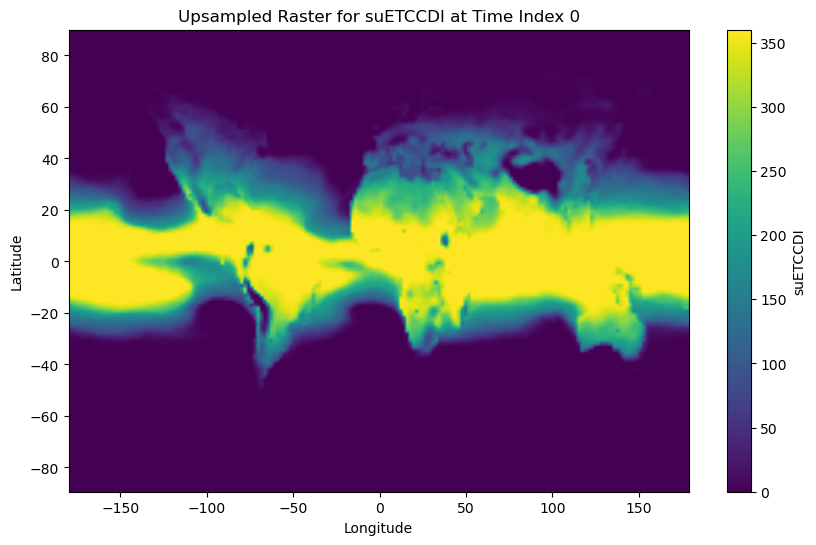

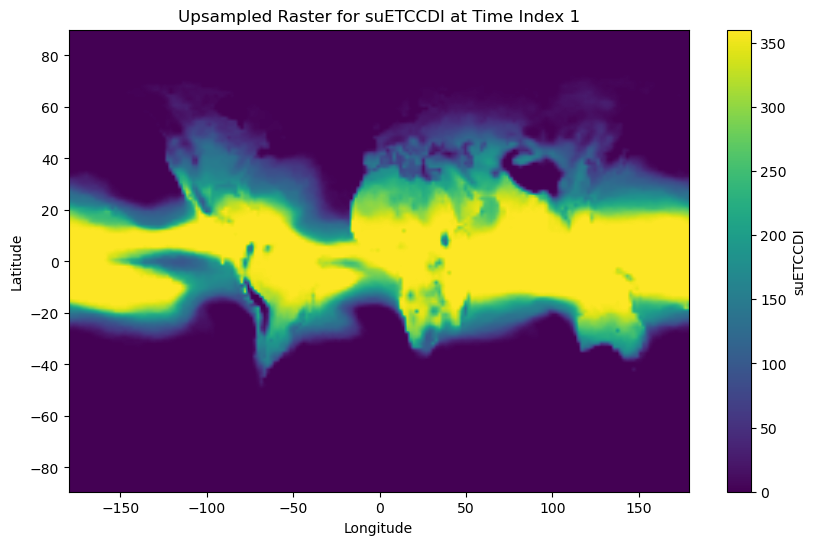

In [41]:
if method == 'raster_query':
    translated_filename = generate_etccdi_temporal_tables__centroid(index_list, etccdi, etccdi_index, report_temporal_dimensions, save_tif)

elif method == 'resample':
    translated_filename = generate_etccdi_temporal_tables(index_list, etccdi, etccdi_index, report_temporal_dimensions, save_tif)

else: 
    print('you have entered a bad prompt for the method parameter. Please restart.... ')

``translated_filename`` retrieves the summary table saved to:


``reference_filtered_time`` retrieves the primary reference table saved to:

In [12]:
report_null_etccdi_values(translated_filename, reference_filtered_time, temporal_aggregation_value)

Total number of null values in 'validate_etccdi' DataFrame: 0
Total number of null values in 'validate_etccdi' DataFrame: 0
therefore, there is no null summary dataframe to report here!


## Now you can migrate to the ingestion script

We want to intentionally keep these things seperate (lock / key) so unwanted things are not automatically ingested

- **Clarify migration to the ingestion script**:


In [ ]:
print( "Now you are ready to run the ingestion code located in .... ")